# Importing Dependancies

In [1]:
import numpy as np
import pandas as pd
import os

import cv2
from tqdm import tqdm
import zipfile as zf
import csv
import gc
import operator
import random

import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.model_selection import train_test_split
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from random import shuffle
from IPython.display import Image
from pathlib import Path

from keras import layers

from keras.models import Model
from keras.models import Sequential

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D

from keras.preprocessing import image

from keras.utils import layer_utils
from keras.utils import plot_model
from keras.utils import np_utils

from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import keras.backend as K

from keras import optimizers

# Preparing images

In [2]:
def prepareImages(data, dataset):
#     print("Preparing images")
    X_train = np.zeros((data.shape[0], 224, 224, 3))
#     X_train_plot = np.zeros((data.shape[0], 224, 224, 3))
#     count = 0
    
    for idx, fig in tqdm(enumerate(data['Image'])):
        #load images into images of size 100x100x3
        img = image.load_img(dataset+"/"+fig, target_size=(224, 224, 3))
        x = image.img_to_array(img)
#         X_train_plot[idx] = x
        
#         img = cv2.cvtColor(img , img , cv2.COLOR_RGBA2RGB)
#         x = ext_frgd(x)
#         x = preprocess_input(x)

        X_train[idx] = x
        
#         if (count%500 == 0):
#             print("Processing image: ", count+1, ", ", fig)
#         count += 1
    
    return X_train#, X_train_plot

def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

df = pd.read_csv('/kaggle/input/humpback-whale-identification/train.csv')
display(df.head())
print(df.shape)
df2 = df[df['Id']!='new_whale']
df2 = df2.groupby('Id').agg('count').rename({'Image': 'NumImages'}, axis=1)
df2.sort_values('NumImages', ascending=False, inplace=True)

NUM_IMAGES_THRESHOLD = 20

df3 = df2.query(f'NumImages > {NUM_IMAGES_THRESHOLD}')

print('shape:', df3.shape)
print('total number of images:', df3.NumImages.sum())
# df3
df_train = df[df['Id'].isin(np.array(df3.index))]
df_train = df_train.reset_index()
display(df_train.head())

X_tr = prepareImages(df_train, "../input/humpback-whale-identification/train")
X_tr /= 255

y_tr,le = prepare_labels(df_train['Id'])

Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale

(25361, 2)
shape: (59, 1)
total number of images: 1977


index          Image         Id
0     26  004e8ad5b.jpg  w_3de579a
1     30  0052ce2f5.jpg  w_2365d55
2     32  00570db6b.jpg  w_9c506f6
3     52  008bf89fc.jpg  w_6822dbc
4     54  00910010d.jpg  w_700ebb4

1977it [00:34, 57.45it/s]


# Viewing the images

100%|██████████| 15/15 [00:00<00:00, 44.51it/s]


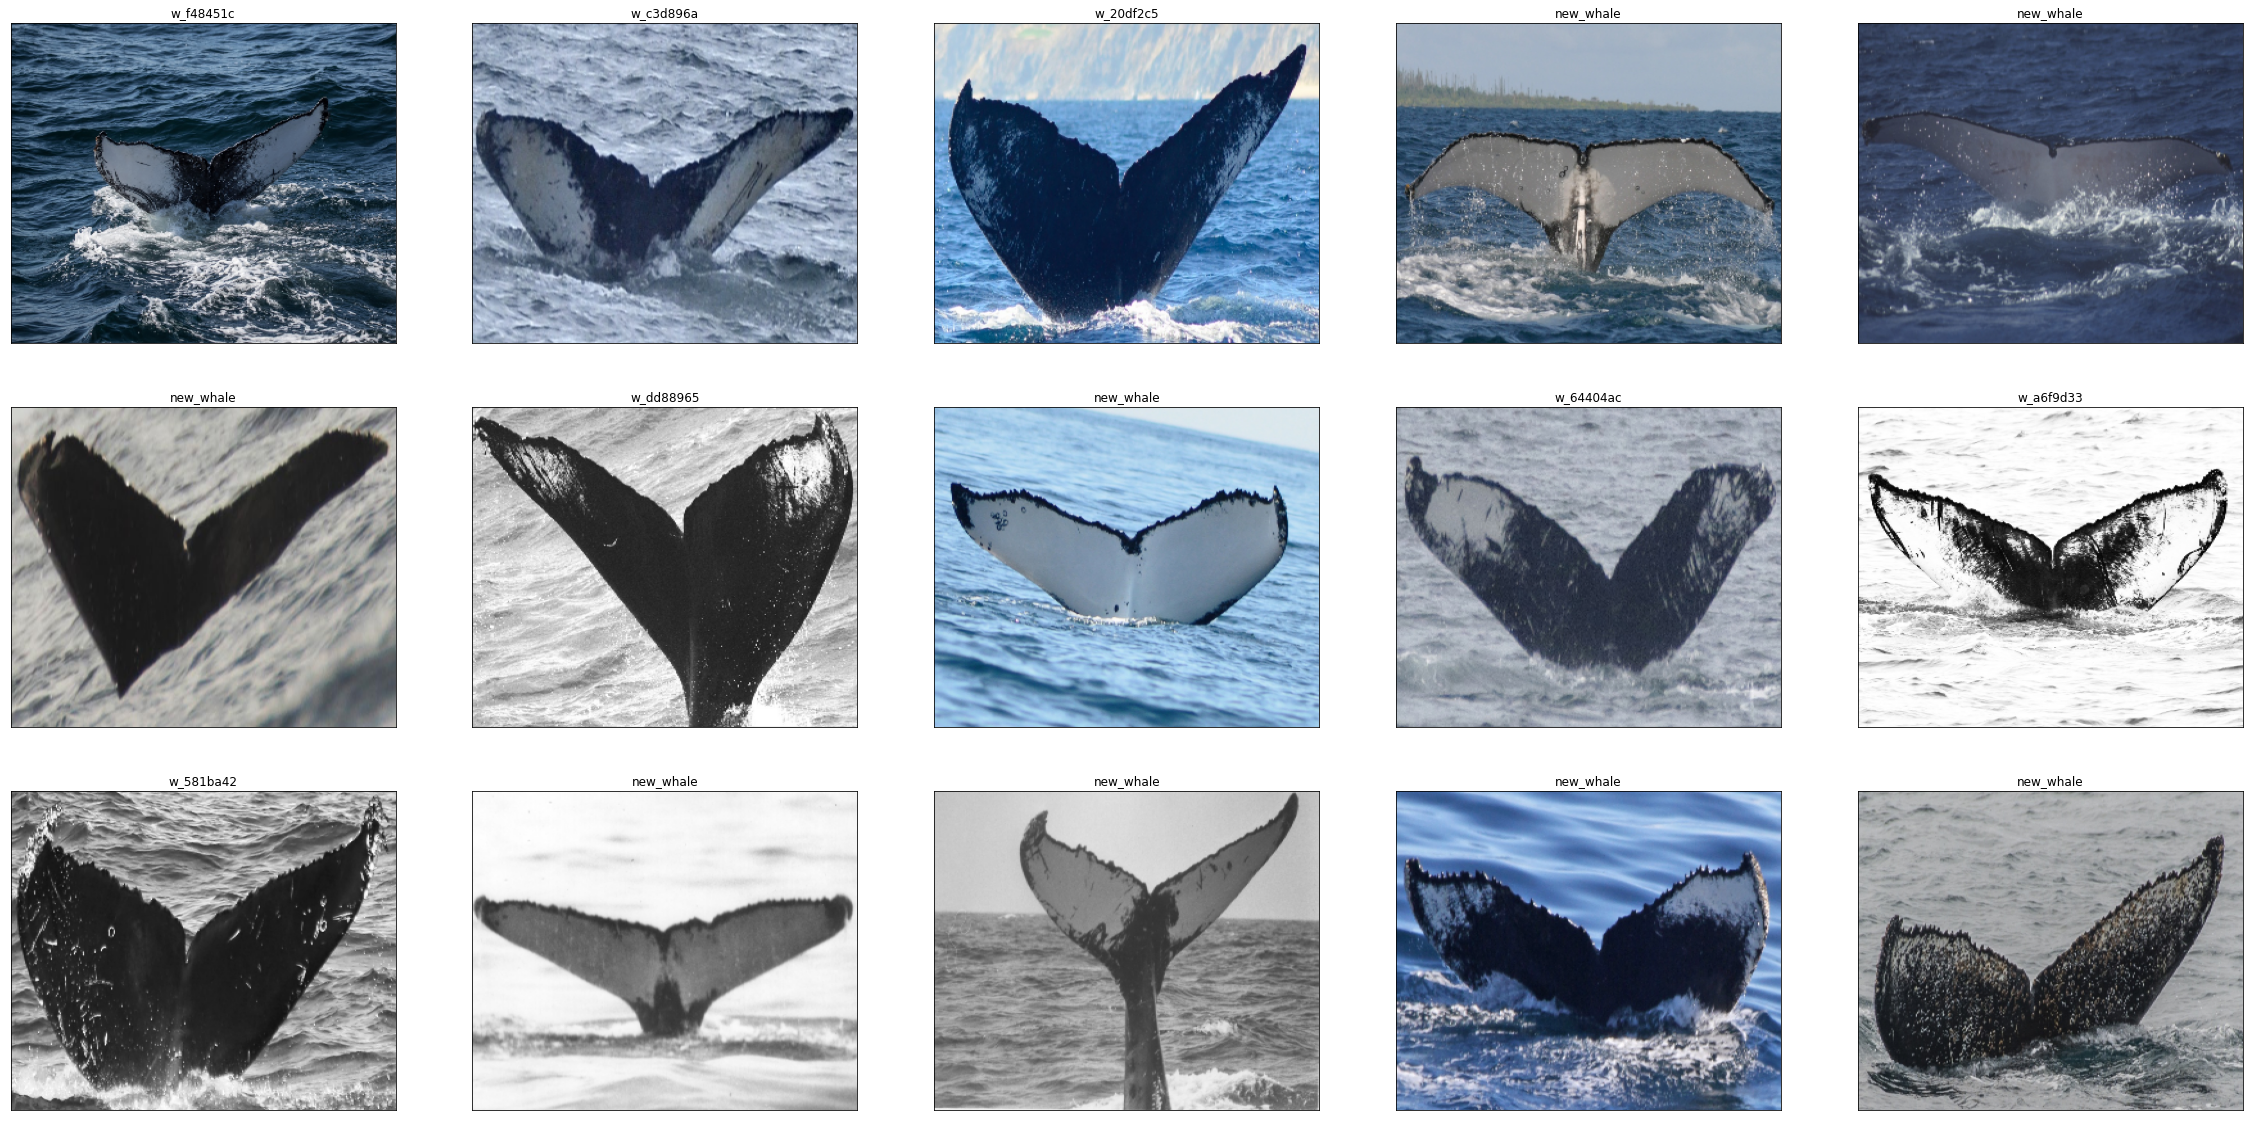

In [3]:
def load(path, size=128):
    img= cv2.resize(cv2.imread(path),(size,size))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def show_image():
    f, ax = plt.subplots(3, 5, figsize=(40,20))
    for i in tqdm(range(15)):
        path= os.path.join('../input/humpback-whale-identification/train', df.Image[i])
        img_id= df.Id[i]
        #img=X[i]
        img=load(path, 300)
        #img_id=y[i]
#         img= adjust_gamma(img, gamma)
        ax[i//5][i%5].imshow(img, aspect='auto')
        ax[i//5][i%5].set_title(img_id)
        ax[i//5][i%5].set_xticks([]); ax[i//5][i%5].set_yticks([])
    plt.show()
show_image()

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.05, random_state=42, stratify=y_tr)
print("Number of training examples : {}".format(X_train.shape[0]))
print("Number of testing examples : {}".format(X_test.shape[0]))
# X_train_plot, X_test_plot, y_train, y_test = train_test_split(X_tr_plot, y_tr, test_size=0.01, random_state=42, shuffle=False)

Number of training examples : 1878
Number of testing examples : 99


[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58]
 [ 1  3  2  2  1  1  2  2  1  4  1  1  2  2  1  3  1  1  2  1  3  1  1  2
   2  2  1  2  1  2  3  1  2  2  2  2  1  1  1  3  3  1  2  2  1  1  1  1
   2  2  1  1  1  1  2  1  2  3  2]]


<BarContainer object of 59 artists>

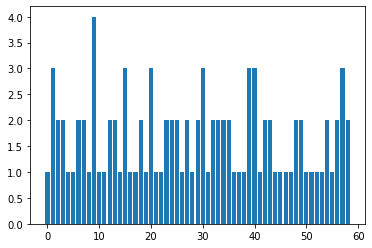

In [49]:
import numpy as np
unique, counts = np.unique(np.argmax(y_test,axis=1), return_counts=True)

print(np.asarray((unique, counts)))

plt.bar(unique, counts)

In [5]:
# from keras.preprocessing import image
# from keras.preprocessing import image
# from keras.applications.imagenet_utils import preprocess_input
# X = np.load('../input/humpback-whales-foreground-extracted/images.npy')
# X = X/255

# y = np.load('../input/humpback-whales-foreground-extracted/labels.npy')
# print("Shape Y-train: ", len(y))
# print(X.shape)

In [6]:
# plt.imshow(cv2.resize(X[0], (224,224), interpolation=cv2.INTER_AREA))
# plt.axis("off")

In [7]:
# y_tr[0][np.argmax(y_tr[0])]
# le.inverse_transform([np.argmax(y_tr[0])])
# plt.imshow(X_tr[0])
# plt.axis("off")
# plt.title("{}: {}".format(np.argmax(y_tr[0]), le.inverse_transform([np.argmax(y_tr[0])])[0]))
# plt.show()

# Modelling

In [8]:
import scipy
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import (DenseNet201,
                                           VGG19,
                                           VGG16,
                                           InceptionResNetV2,
                                           ResNet152V2, 
                                           ResNet50)

from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

## Helper functions

In [9]:
def model_builder(model_val,INPUT_SHAPE):
    base_model = model_val(
        weights='imagenet',  # load weights pretrained on the ImageNet
        include_top=False,  # do not include the ImageNet classifier at the top
        input_shape=INPUT_SHAPE,
#         name='base_model'
#         pooling='max'  # add a global max pooling layer after the base model
    )
    
    base_model.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # add a flatten layer
    x = Flatten()(x)
    # and a fully connected output/classification layer
    predictions = Dense(59, activation='softmax')(x)
    # create the full network so we can train on it
    model_transfer = Model(inputs=base_model.input, outputs=predictions)
    

#     model = keras.Sequential([
#         base_model,
#         GlobalAveragePooling2D(name='Pooled_layer'),
# #         Dropout(0.2),
# # #         Dense(512, activation='relu'),
# # #         Dense(256, activation='relu'),
#         Dense(128, activation='relu'),
#         Dense(128, activation='relu'),
# # #         Dropout(0.2),
#         Dense(59, name='predictions')
#     ])
    return model_transfer

def train_funct(model, X, y, epochs=25):
    FINE_TUNING_EPOCHS = epochs
#     checkpoint_filepath = './temp/checkpoint'
#     model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#             filepath=checkpoint_filepath,
#             save_weights_only=True,
#             monitor='val_accuracy',
#             mode='max',
#             save_best_only=True)
    model.compile(optimizer=Adam(1e-4), 
                  loss=CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    fine_tuning_history = model.fit(X,y, 
                                    epochs=FINE_TUNING_EPOCHS,
                                    validation_split=0.2,
                                    verbose=1,
#                                     callbacks=[model_checkpoint_callback]
    )
    return model,fine_tuning_history


def get_class_activation_map224(model, img):
    ''' 
    this function computes the class activation map
    
    Inputs:
        1) model (tensorflow model) : trained model
        2) img (numpy array of shape (224, 224, 3)) : input image
    '''
    
    # expand dimension to fit the image to a network accepted input size
#     img = np.expand_dims(img, axis=0)

    # predict to get the winning class
    img = np.array([img])
    predictions = model.predict(img)
    label_index = np.argmax(predictions)

    # Get the 2048 input weights to the softmax of the winning class.
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]
    
    # get the final conv layer
    final_conv_layer = model.get_layer("conv5_block3_out")
    
    # create a function to fetch the final conv layer output maps (should be shape (1, 7, 7, 2048)) 
    get_output = K.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    # squeeze conv map to shape image to size (7, 7, 2048)
    conv_outputs = np.squeeze(conv_outputs)
#     print(conv_outputs.shape)
    
    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (32, 32, 1), order=1) # dim: 224 x 224 x 2048
#     print(mat_for_mult.shape)
    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((224*224, 2048)), class_weights_winner).reshape(224, 224) # dim: 224 x 224
    
    # return class activation map
    return final_output, label_index, predictions[0][label_index]


def get_occ_map(model, CAT_CLASS_INDEX, img):
    PATCH_SIZE = 4

    sensitivity_map = np.zeros((img.shape[0], img.shape[1]))

    # Iterate the patch over the image
    for top_left_x in tqdm(range(0, img.shape[0], PATCH_SIZE)):
        for top_left_y in range(0, img.shape[1], PATCH_SIZE):
            patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
#             plt.imshow(patched_image)
#             plt.show()
            predicted_classes = model.predict(np.array([patched_image]))[0]
            confidence = predicted_classes[CAT_CLASS_INDEX]

            # Save confidence for this specific patched image in map
            sensitivity_map[
                top_left_y:top_left_y + PATCH_SIZE,
                top_left_x:top_left_x + PATCH_SIZE,
            ] = confidence
    return sensitivity_map

In [10]:
TARGET_SIZE = (224,224)
INPUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
resnet50model = model_builder(ResNet50, INPUT_SHAPE)

# mod1.summary()
model_trained = []
models = [ResNet50,VGG16,InceptionResNetV2]#,ResNet152V2, VGG19, DenseNet201]
for model in tqdm(models):
    resnet50model = model_builder(ResNet50, INPUT_SHAPE)
    resnet50model ,_ = train_funct(resnet50model, X_train, y_train)
    model_trained.append(resnet50model)

94773248/94765736 [==============================] - 1s 0us/step


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/25
47/47 [==============================] - 20s 238ms/step - loss: 3.7368 - accuracy: 0.1501 - val_loss: 4.6807 - val_accuracy: 0.0346
Epoch 2/25
47/47 [==============================] - 9s 192ms/step - loss: 0.7618 - accuracy: 0.8826 - val_loss: 4.4599 - val_accuracy: 0.0133
Epoch 3/25
47/47 [==============================] - 9s 190ms/step - loss: 0.0977 - accuracy: 0.9950 - val_loss: 4.5759 - val_accuracy: 0.0133
Epoch 4/25
47/47 [==============================] - 9s 190ms/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 4.5954 - val_accuracy: 0.0133
Epoch 5/25
47/47 [==============================] - 9s 191ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 4.6506 - val_accuracy: 0.0133
Epoch 6/25
47/47 [==============================] - 9s 192ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 4.6524 - val_accuracy: 0.0133
Epoch 7/25
47/47 [==============================] - 9s 190ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 4.6468 - val_accuracy: 0.0133
Epoch

 33%|███▎      | 1/3 [03:57<07:54, 237.34s/it]

Epoch 1/25
47/47 [==============================] - 15s 215ms/step - loss: 3.7798 - accuracy: 0.1449 - val_loss: 4.1771 - val_accuracy: 0.0213
Epoch 2/25
47/47 [==============================] - 9s 191ms/step - loss: 0.7965 - accuracy: 0.8803 - val_loss: 4.2267 - val_accuracy: 0.0133
Epoch 3/25
47/47 [==============================] - 9s 191ms/step - loss: 0.1132 - accuracy: 0.9948 - val_loss: 4.4038 - val_accuracy: 0.0133
Epoch 4/25
47/47 [==============================] - 9s 190ms/step - loss: 0.0304 - accuracy: 1.0000 - val_loss: 4.5794 - val_accuracy: 0.0133
Epoch 5/25
47/47 [==============================] - 9s 190ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 4.5756 - val_accuracy: 0.0133
Epoch 6/25
47/47 [==============================] - 9s 190ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 4.5769 - val_accuracy: 0.0133
Epoch 7/25
47/47 [==============================] - 9s 190ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 4.5431 - val_accuracy: 0.0133
Epoch

 67%|██████▋   | 2/3 [07:49<03:54, 234.17s/it]

Epoch 1/25
47/47 [==============================] - 15s 216ms/step - loss: 3.7899 - accuracy: 0.1348 - val_loss: 4.5532 - val_accuracy: 0.0080
Epoch 2/25
47/47 [==============================] - 9s 190ms/step - loss: 0.8689 - accuracy: 0.8665 - val_loss: 4.4059 - val_accuracy: 0.0160
Epoch 3/25
47/47 [==============================] - 9s 190ms/step - loss: 0.1160 - accuracy: 0.9963 - val_loss: 4.3114 - val_accuracy: 0.0213
Epoch 4/25
47/47 [==============================] - 9s 190ms/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 4.3817 - val_accuracy: 0.0213
Epoch 5/25
47/47 [==============================] - 9s 190ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 4.4061 - val_accuracy: 0.0186
Epoch 6/25
47/47 [==============================] - 9s 192ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 4.4040 - val_accuracy: 0.0239
Epoch 7/25
47/47 [==============================] - 9s 190ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 4.3888 - val_accuracy: 0.0266
Epoch

100%|██████████| 3/3 [11:40<00:00, 233.56s/it]


In [11]:
# resnet50model.summary()

In [ ]:
# # resnet50model.save('./model_saved_resnet50.h5')
# import tensorflow as tf
# import tensorflow.keras as keras
# resnet50model = keras.models.load_model('../input/humpback-whales-foreground-extracted/model_saved_resnet50.h5')

In [13]:
# model_trained[0]

In [26]:
preds_list = []
for model in tqdm(model_trained):
    preds = model.predict(X_test)
    preds_list.append(preds)
    from sklearn.metrics import accuracy_score
    print(accuracy_score(np.argmax(preds,axis=1), np.argmax(y_test,axis=1)))

 33%|███▎      | 1/3 [00:00<00:00,  3.44it/s]

0.898989898989899


 67%|██████▋   | 2/3 [00:00<00:00,  3.58it/s]

0.8787878787878788


100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

0.8888888888888888


0it [00:00, ?it/s]

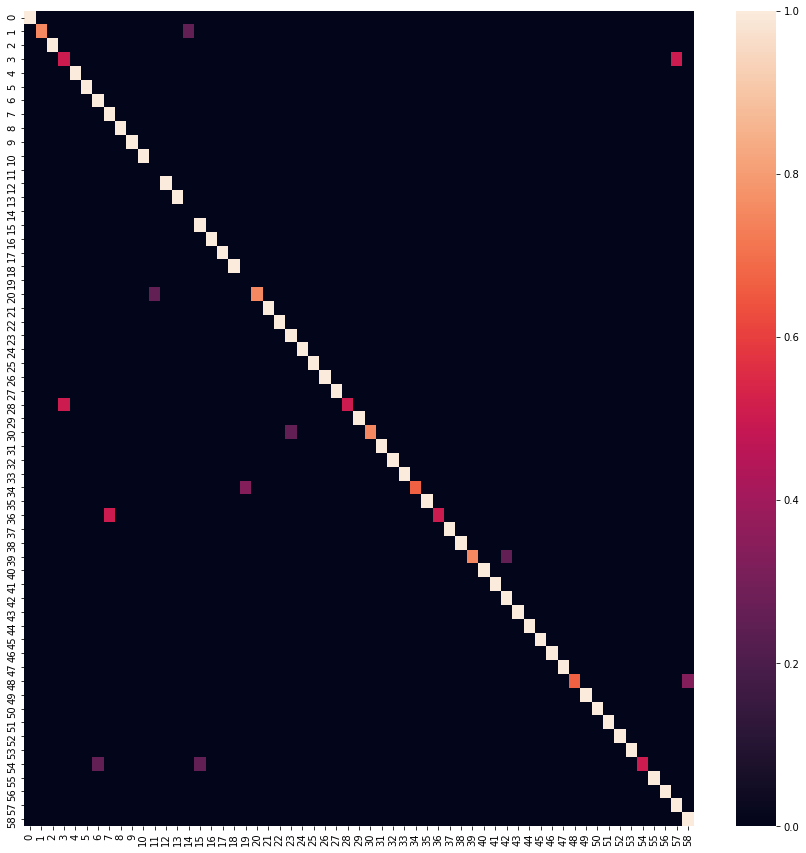

1it [00:01,  1.29s/it]

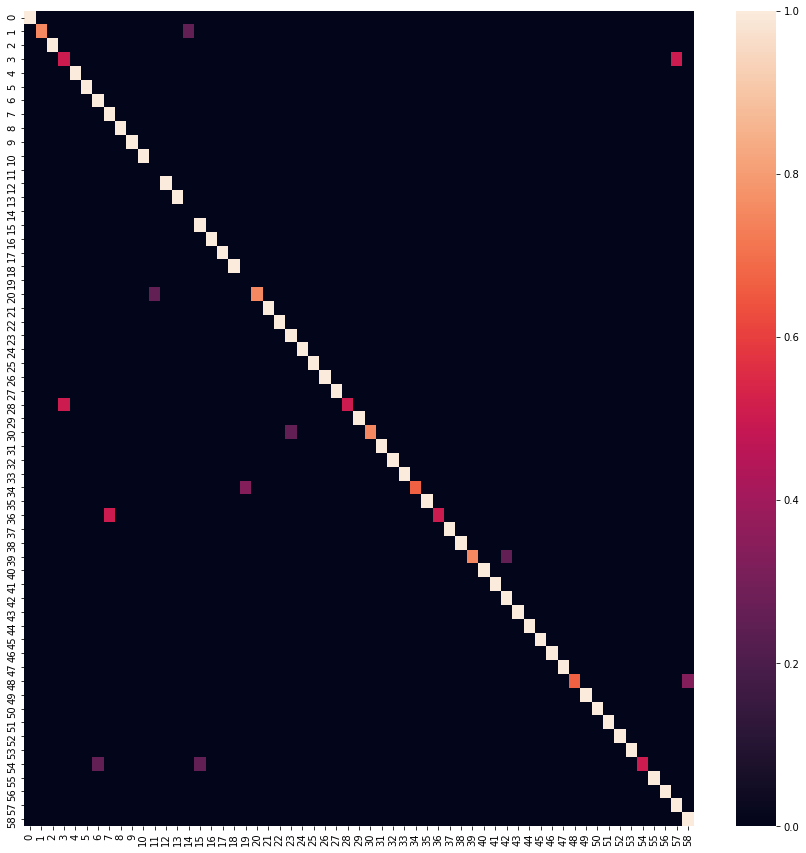

2it [00:02,  1.41s/it]

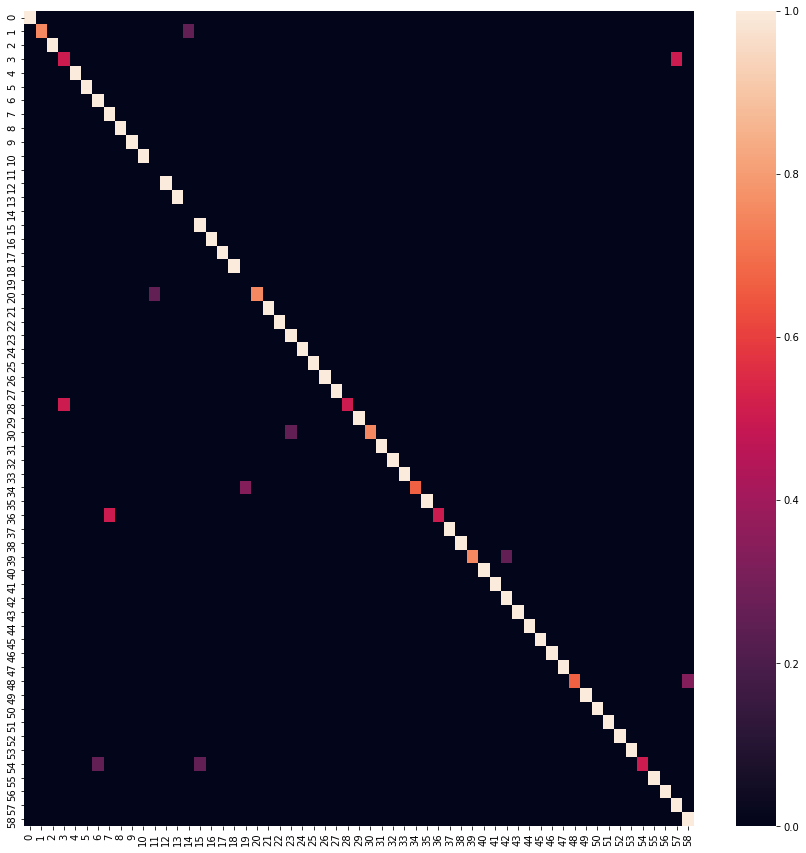

3it [00:04,  1.37s/it]


In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

for idx, model in tqdm(enumerate(model_trained)):
    plt.figure(figsize=(15,15))
    sns.heatmap(confusion_matrix(np.argmax(preds,axis=1), np.argmax(y_test,axis=1), normalize='true'))
#     print(preds_list[idx].shape)
    plt.show()

In [36]:
X,Xs = [],[]
# idx=0
for j in range(np.array(model_trained).shape[0]):
    for i in tqdm(range(preds_list[j].shape[0])):
        if np.argmax(preds_list[j][i])!=np.argmax(y_test[i]):
            X.append(i)
    Xs.append(X)

cams2, labels2, confs2, y_labels2, plot_imgs2 = [], [], [], [], []
for idxs, model in tqdm(enumerate(model_trained)):
    cams, labels, confs, y_labels, plot_imgs = [], [], [], [], []
    for idx in Xs[idxs][:2]:
        cam2, label2, conf2 = get_class_activation_map224(model, np.array(np.array(X_test[idx])))
        plot_imgs.append(X_test[idx])
        cams.append(cam2)
        labels.append(label2)
        confs.append(conf2)
        y_labels.append(np.argmax(y_test[idx]))
        
    plot_imgs2.append(plot_imgs)
    cams2.append(cams)
    labels2.append(labels)
    confs2.append(confs)
    y_labels2.append(y_labels)

100%|██████████| 99/99 [00:00<00:00, 20954.59it/s]
3it [00:32, 10.99s/it]


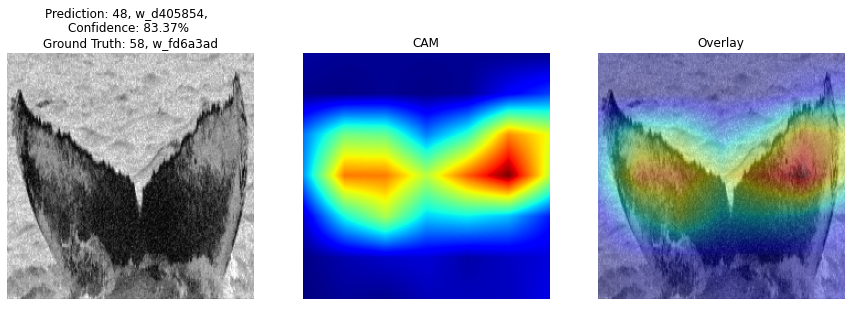

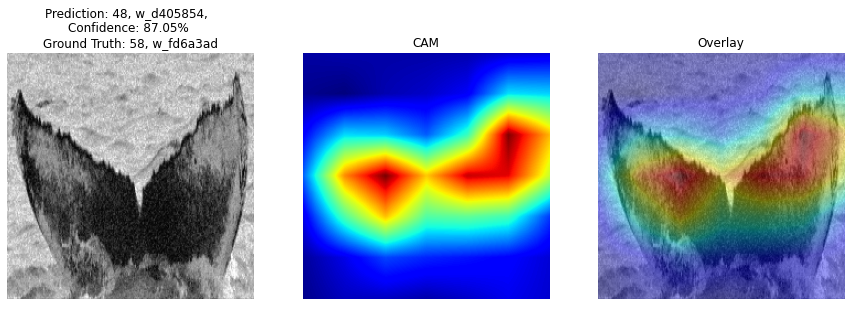

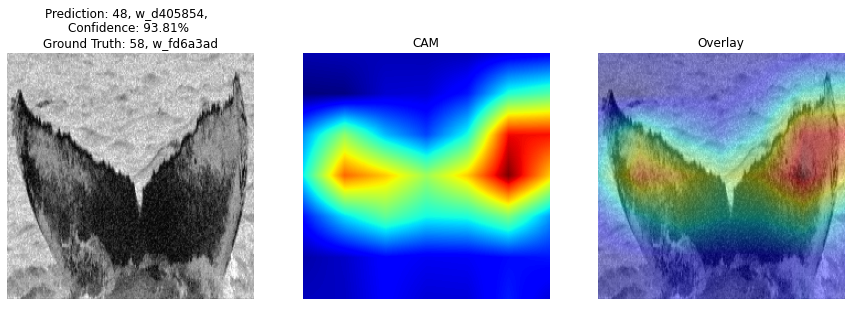

In [37]:
for j in range(np.array(y_labels2).shape[0]):
    for i in range(1) : 
        rows = 1
        columns = 3
        # idx = 0

        fig = plt.figure(figsize=(15, 5))
    #     plt.title("With model trained on With background dataset")
        plt.axis('off')

        fig.add_subplot(rows, columns, 1)
        plt.imshow(plot_imgs[i])
        plt.axis('off')
    #     plt.title("{} : {}%".format(labels[i], round(confs[i]*100,2)))
        plt.title("Prediction: {}, {},  \nConfidence: {}% \nGround Truth: {}, {}".format(labels2[j][i], le.inverse_transform([labels2[j][i]])[0], round(confs2[j][i]*100,2), y_labels2[j][i], le.inverse_transform([y_labels2[j][i]])[0]))

        fig.add_subplot(rows, columns, 2)
        plt.imshow(cams2[j][i], cmap='jet')
        plt.axis('off')
        plt.title("CAM")
    #     plt.show()

        fig.add_subplot(rows, columns, 3)
        plt.imshow(plot_imgs[i])
        plt.imshow(cams2[j][i], cmap='jet', alpha=0.4)
        plt.axis('off')
        plt.title("Overlay")
        plt.show()

In [38]:
X,Xs = [],[]
# idx=0
for j in range(np.array(model_trained).shape[0]):
    for i in tqdm(range(preds_list[j].shape[0])):
        if np.argmax(preds_list[j][i])==np.argmax(y_test[i]):
            X.append(i)
    Xs.append(X)

cams2, labels2, confs2, y_labels2, plot_imgs2 = [], [], [], [], []
for idxs, model in tqdm(enumerate(model_trained)):
    cams, labels, confs, y_labels, plot_imgs = [], [], [], [], []
    for idx in Xs[idxs][:2]:
        cam2, label2, conf2 = get_class_activation_map224(model, np.array(np.array(X_test[idx])))
        plot_imgs.append(X_test[idx])
        cams.append(cam2)
        labels.append(label2)
        confs.append(conf2)
        y_labels.append(np.argmax(y_test[idx]))
        
    plot_imgs2.append(plot_imgs)
    cams2.append(cams)
    labels2.append(labels)
    confs2.append(confs)
    y_labels2.append(y_labels)

100%|██████████| 99/99 [00:00<00:00, 70847.31it/s]
3it [00:33, 11.06s/it]


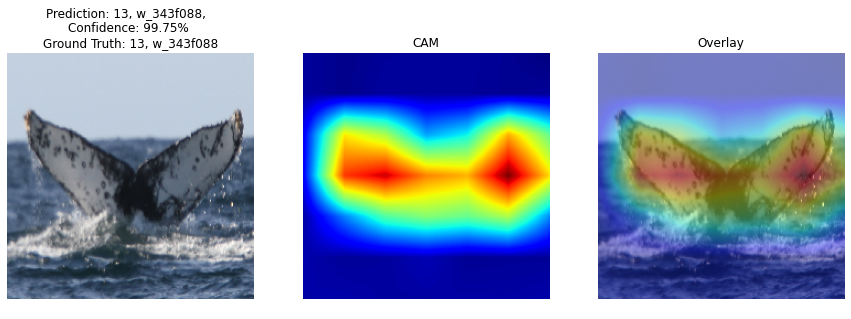

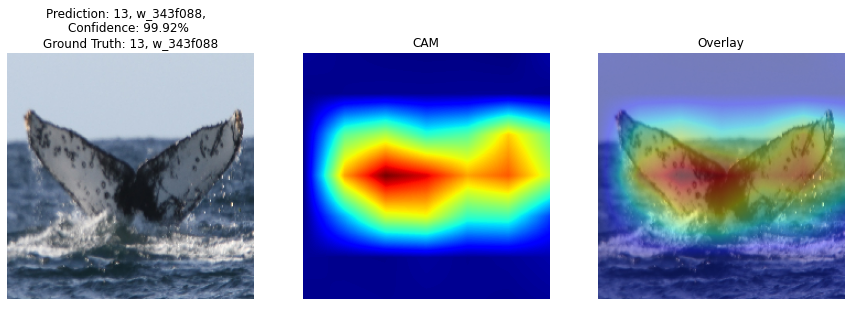

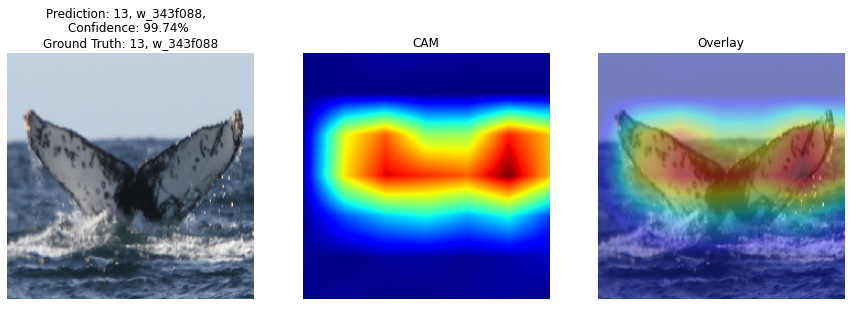

In [39]:
for j in range(np.array(y_labels2).shape[0]):
    for i in range(1) : 
        rows = 1
        columns = 3
        # idx = 0

        fig = plt.figure(figsize=(15, 5))
    #     plt.title("With model trained on With background dataset")
        plt.axis('off')

        fig.add_subplot(rows, columns, 1)
        plt.imshow(plot_imgs[i])
        plt.axis('off')
    #     plt.title("{} : {}%".format(labels[i], round(confs[i]*100,2)))
        plt.title("Prediction: {}, {},  \nConfidence: {}% \nGround Truth: {}, {}".format(labels2[j][i], le.inverse_transform([labels2[j][i]])[0], round(confs2[j][i]*100,2), y_labels2[j][i], le.inverse_transform([y_labels2[j][i]])[0]))

        fig.add_subplot(rows, columns, 2)
        plt.imshow(cams2[j][i], cmap='jet')
        plt.axis('off')
        plt.title("CAM")
    #     plt.show()

        fig.add_subplot(rows, columns, 3)
        plt.imshow(plot_imgs[i])
        plt.imshow(cams2[j][i], cmap='jet', alpha=0.4)
        plt.axis('off')
        plt.title("Overlay")
        plt.show()

# Trials 

In [ ]:
# def prepareImages(data, dataset):
# #     print("Preparing images")
#     X_train = np.zeros((data.shape[0], 224,224, 3))
# #     count = 0
    
#     for idx, fig in tqdm(enumerate(data['Image'])):
#         #load images into images of size 100x100x3
#         img = image.load_img(dataset+"/"+fig, target_size=(224,224, 3))
#         x = image.img_to_array(img)
# #         img = cv2.cvtColor(img , img , cv2.COLOR_RGBA2RGB)
# #         x = ext_frgd(x)
# #         x = preprocess_input(x)

#         X_train[idx] = x
# #         if (count%500 == 0):
# #             print("Processing image: ", count+1, ", ", fig)
# #         count += 1
    
#     return X_train

# X_tr_plot = prepareImages(df_train, "../input/humpback-whale-identification/train")
# X_tr_plot /= 255

In [ ]:
for idx in range(5):
    

In [ ]:
# for 

In [ ]:
# preds = resnet50model.predict(X_test)
# from sklearn.metrics import accuracy_score
# accuracy_score(np.argmax(preds,axis=1), np.argmax(y_test,axis=1))

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
last_conv_layer_name = "conv5_block3_out"
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img_array = np.array([preprocess_input(np.array(X_test[0]))])
preds = resnet50model.predict(img_array)
label = np.argmax(preds[0])
print("Predicted: {}, {}, Confidence: {}%\n Original: {}".format(label, le.inverse_transform(np.array([label]))[0], round(preds[0][label]*100, 2), np.argmax(y_test[0])))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, resnet50model, last_conv_layer_name)

# # Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
plt.imshow(cv2.cvtColor(jet_heatmap, cv2.COLOR_BGR2RGB ), cmap='coolwarm')

In [ ]:
plt.imshow(X_test[0])
plt.imshow(jet_heatmap, alpha=0.5)

In [ ]:
import matplotlib.cm as cm
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
#     img = keras.preprocessing.image.load_img(img_path)
#     img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    
    return jet


jet_heatmap = save_and_display_gradcam(X_test[0], heatmap)

In [ ]:
plt.imshow(X_test[0])
# plt.imshow(jet_heatmap)

In [ ]:
import scipy
def get_class_activation_map(model, img):
    ''' 
    this function computes the class activation map
    
    Inputs:
        1) model (tensorflow model) : trained model
        2) img (numpy array of shape (224, 224, 3)) : input image
    '''
    
    # expand dimension to fit the image to a network accepted input size
#     img = np.expand_dims(img, axis=0)

    # predict to get the winning class
    img = np.array([img])
    predictions = model.predict(img)
    label_index = np.argmax(predictions)
#     print(predictions[0][label_index])

    # Get the 2048 input weights to the softmax of the winning class.
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]
    
    # get the final conv layer
    final_conv_layer = model.get_layer("conv5_block3_out")
    
    # create a function to fetch the final conv layer output maps (should be shape (1, 7, 7, 2048)) 
    get_output = K.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    # squeeze conv map to shape image to size (7, 7, 2048)
    conv_outputs = np.squeeze(conv_outputs)
    print(conv_outputs.shape)
    
    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (25, 25, 1), order=1) # dim: 224 x 224 x 2048
    print(mat_for_mult.shape)
    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((100*100, 2048)), class_weights_winner).reshape(100, 100) # dim: 224 x 224
    
    # return class activation map
    return final_output, label_index, predictions[0][label_index]

In [ ]:
# mod1 = keras.models.load_model('../input/humpback-whales-foreground-extracted/model_resnet50_withbackground.h5')
# mod2 = keras.models.load_model('../input/humpback-whales-foreground-extracted/model_resnet50_withnobackground.h5')

In [ ]:
np.argmax(y_test,axis=1)

In [ ]:
TARGET_SIZE = (224,224)
INPUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
mod2 = model_builder(InceptionResNetV2, INPUT_SHAPE)

# mod1.summary()
model2 ,_ = train_funct(mod1, X_train, y_train)
# model.get_layer("Pooled_layer").output
# K.function([model.layers[0].input],[model.get_layer("Pooled_layer").output, model.layers[-1].output])
# model.get_layer("conv_7b").output

In [ ]:
import scipy
def get_class_activation_map(model, img, model_out):
    ''' 
    this function computes the class activation map
    
    Inputs:
        1) model (tensorflow model) : trained model
        2) img (numpy array of shape (224, 224, 3)) : input image
    '''
    
    # expand dimension to fit the image to a network accepted input size
#     img = np.expand_dims(img, axis=0)

    # predict to get the winning class
    img = np.array([img])
    predictions = model_out.predict(img)
    label_index = np.argmax(predictions)
#     print(predictions[0][label_index])

    # Get the 2048 input weights to the softmax of the winning class.
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]
    
    # get the final conv layer
    final_conv_layer = model.get_layer("conv_7b_ac")
    
    # create a function to fetch the final conv layer output maps (should be shape (1, 7, 7, 2048)) 
    get_output = K.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    # squeeze conv map to shape image to size (7, 7, 2048)
    conv_outputs = np.squeeze(conv_outputs)
    print(conv_outputs.shape)
    
    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (44.8, 44.8, 1), order=1) # dim: 224 x 224 x 2048
    print(mat_for_mult.shape)
    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult.reshape((224*224, 1536)), class_weights_winner).reshape(224, 224) # dim: 224 x 224
    
    # return class activation map
    return final_output, label_index, predictions[0][label_index]

In [ ]:
# mod2.summary()

In [ ]:
idx=1

# cam1, label1, conf1 = get_class_activation_map(mod1, X[idx])
cam2, label2, conf2 = get_class_activation_map(resnet50model, X_test[idx],model2)

In [ ]:
ori_out = np.argmax(y_test[idx])
plt.imshow(X_test[idx])
plt.imshow(cam2, cmap='jet', alpha=0.2)
plt.title("Original : {}\nPredicted : {} Confidence:{}%".format(ori_out, label2, round(conf2*100,2)))
plt.axis("off")
plt.show()

In [ ]:
np.argmax(y_test,axis=1)

In [ ]:
np.argmax(preds,axis=1)

In [ ]:
preds = model2.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(preds,axis=1), np.argmax(y_test,axis=1))

In [ ]:
# def occ_sens_plot_both(img1,img_fg1,s1,s2, img2,img_fg2,s3,s4):
#     f, ax = plt.subplots(1, 4, figsize=(15,15))
#     ax[0].imshow(img1)
#     ax[0].imshow(s1,cmap='jet',alpha=0.5)
# #     ax[0].suptitle("{} : {}%".format(np.argmax(y_tr[0]), y_tr[0][np.argmax(y_tr[0])]*100))
#     ax[1].imshow(img_fg1)
#     ax[1].imshow(s2,cmap='jet',alpha=0.5)
    
#     ax[2].imshow(img2)
#     ax[2].imshow(s3,cmap='jet',alpha=0.5)
#     ax[3].imshow(img_fg2)
#     ax[3].imshow(s4,cmap='jet',alpha=0.5)

#     plt.show()
    
# def plot_original(idx1,idx2):
#     f, ax = plt.subplots(1, 4, figsize=(15,15))
#     ax[0].imshow(X_tr_plot[idx1])
#     ax[1].imshow(X[idx1])
#     ax[2].imshow(X_tr_plot[idx2])
#     ax[3].imshow(X[idx2])
#     plt.show()
    
    
# def make_cam(idx1,idx2):
#     CAM1, label1, conf1 = get_class_activation_map(model, X_tr[idx1])
#     CAM2, label2, conf2 = get_class_activation_map(model, X[idx1])
#     CAM3, label3, conf3 = get_class_activation_map(model, X_tr[idx2])
#     CAM4, label4, conf4 = get_class_activation_map(model, X[idx2])
    
#     plot_original(idx1,idx2)
    
#     occ_sens_plot_both(X_tr_plot[idx1],X[idx1],CAM1,CAM2, X_tr_plot[idx2],X[idx2],CAM3,CAM4)

In [ ]:
# make_cam(75, 15)

In [ ]:
# idx = 4 for faulty output

In [ ]:
# cam2, label2, conf2 = get_class_activation_map224(mod1, preprocess_input(cv2.resize(X[3], (224, 224),interpolation = cv2.INTER_NEAREST)))

In [ ]:
# plt.imshow(cv2.resize(X[3], (224, 224),interpolation = cv2.INTER_NEAREST))
# plt.imshow(cam2, cmap='jet', alpha=0.4)

In [ ]:
# plt.imshow(X_train[idx])

In [ ]:
X_test[idx].shape

In [ ]:
# 

In [ ]:
ori_out = np.argmax(y_test[idx])
plt.imshow(X_test[idx])
plt.imshow(cam2, cmap='jet', alpha=0.2)
plt.title("Original : {}\nPredicted : {} Confidence:{}%".format(ori_out, label2, round(conf2*100,2)))
plt.axis("off")
plt.show()

In [ ]:
plt.imshow(cam2, cmap='jet')

In [ ]:
rows = 2
columns = 3
# idx = 0

fig = plt.figure(figsize=(15, 15))
plt.title("With model trained on With background dataset")
plt.axis('off')

fig.add_subplot(rows, columns, 1)
plt.imshow(X_tr_plot[idx])
plt.axis('off')
plt.title("{} : {}%".format(label2, round(conf2*100,2)))

fig.add_subplot(rows, columns, 2)
plt.imshow(cam2, cmap='jet')
plt.axis('off')
plt.title("CAM")

fig.add_subplot(rows, columns, 3)

plt.imshow(X_tr_plot[idx])
plt.imshow(cam2, cmap='jet', alpha=0.4)
plt.axis('off')
plt.title("Overlay")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 4)
plt.imshow(X[idx])
plt.axis('off')
plt.title("{} : {}%".format(label1, round(conf1*100),2))

fig.add_subplot(rows, columns, 5)
plt.imshow(cam1, cmap='jet')
plt.axis('off')
plt.title("CAM")

fig.add_subplot(rows, columns, 6)
plt.imshow(X[idx])
plt.imshow(cam1, cmap='jet', alpha=0.4)
plt.axis('off')
plt.title("Overlay")

plt.tight_layout()
plt.show()

########################################################################################
########################################################################################

In [ ]:
rows = 2
columns = 3

fig = plt.figure(figsize=(15, 15))
plt.title("With model trained on Foreground extracted dataset")
plt.axis('off')

fig.add_subplot(rows, columns, 1)
plt.imshow(X_tr_plot[idx])
plt.axis('off')
plt.title("{} : {}%".format(label4, round(conf4*100,2)))

fig.add_subplot(rows, columns, 2)
plt.imshow(cam4, cmap='jet')
plt.axis('off')
plt.title("CAM")

fig.add_subplot(rows, columns, 3)

plt.imshow(X_tr_plot[idx])
plt.imshow(cam4, cmap='jet', alpha=0.4)
plt.axis('off')
plt.title("Overlay")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 4)
plt.imshow(X[idx])
plt.axis('off')
plt.title("{} : {}%".format(label3, round(conf3*100),2))

fig.add_subplot(rows, columns, 5)
plt.imshow(cam3, cmap='jet')
plt.axis('off')
plt.title("CAM")

fig.add_subplot(rows, columns, 6)
plt.imshow(X[idx])
plt.imshow(cam3, cmap='jet', alpha=0.4)
plt.axis('off')
plt.title("Overlay")

plt.tight_layout()
plt.show()

In [ ]:
# def train_funct(model):
#     FINE_TUNING_EPOCHS = 25
# #     checkpoint_filepath = './temp/checkpoint'
# #     model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
# #             filepath=checkpoint_filepath,
# #             save_weights_only=True,
# #             monitor='val_accuracy',
# #             mode='max',
# #             save_best_only=True)
#     model.compile(optimizer=Adam(1e-4), 
#                   loss=CategoricalCrossentropy(from_logits=True),
#                   metrics=['accuracy'])
#     fine_tuning_history = model.fit(X_tr,y_tr, 
#                                     epochs=FINE_TUNING_EPOCHS,
#                                     validation_split=0.2,
#                                     verbose=1,
# #                                     callbacks=[model_checkpoint_callback]
#     )
#     return model,fine_tuning_history


In [ ]:
# mode2 ,_ = train_funct(mod1)

In [ ]:
mod1.save('./model_resnet50_withbackground.h5')

In [ ]:
mode2.save('./model_resnet50_withnobackground.h5')

In [ ]:
mode2 = keras.models.load_model('./model_resnet50_withnobackground.h5')

In [ ]:
cam, label, conf = get_class_activation_map(mode2, X[121])
cam2, label2, conf2 = get_class_activation_map(mode2, X_tr[121])

In [ ]:
plt.imshow(X[121])

In [ ]:
CAM1, label1 = get_class_activation_map(model, X_tr[0])
CAM2, label2 = get_class_activation_map(model, X[0])
CAM3, label3 = get_class_activation_map(model, X_tr[314])
CAM4, label4 = get_class_activation_map(model, X[313])

In [ ]:
def occ_sens_plot_both(img1,img_fg1,s1,s2, img2,img_fg2,s3,s4):
    f, ax = plt.subplots(1, 4, figsize=(15,15))
    ax[0].imshow(img1)
    ax[0].imshow(s1,cmap='jet',alpha=0.5)
    ax[1].imshow(img_fg1)
    ax[1].imshow(s2,cmap='jet',alpha=0.5)
    
    ax[2].imshow(img2)
    ax[2].imshow(s3,cmap='jet',alpha=0.5)
    ax[3].imshow(img_fg2)
    ax[3].imshow(s4,cmap='jet',alpha=0.5)

    plt.show()

def plot_original():
    f, ax = plt.subplots(1, 4, figsize=(15,15))
    ax[0].imshow(X_tr_plot[0])
    ax[1].imshow(X[0])
    ax[2].imshow(X_tr_plot[314])
    ax[3].imshow(X[313])
    plt.show()

In [ ]:
plot_original()

In [ ]:
occ_sens_plot_both(X_tr_plot[0],X[0],CAM1,CAM2, X_tr_plot[314],X[313],CAM3,CAM4)

In [ ]:
plt.imshow(X_tr[100])
plt.imshow(CAM, cmap='jet', alpha=0.5)
plt.title(label)
plt.colorbar()

In [ ]:
CAM, label = get_class_activation_map(model, X[100])
plt.imshow(X[100])
plt.imshow(CAM, cmap='jet', alpha=0.5)
plt.title(label)
plt.colorbar()

In [ ]:
plt.imshow(X_tr[30])

In [ ]:
plt.imshow(X[30])

In [ ]:
def plot_class_activation_map(CAM, img, label, data_path, ax):
    ''' 
    this function plots the activation map 
    
    Inputs:
        1) CAM (numpy array of shape (224, 224)) : class activation map containing the trained heat map
        2) img (numpy array of shape (224, 224, 3)) : input image
        3) label (uint8) : index of the winning class
        4) data_path (string) : path to the images -> used to extract the class labels by extracting all local subdirs
        5) ax (matplotlib axes) : axes where current CAM should be plotted
    '''
    
    # plot image
    ax.imshow(img, alpha=0.5)
    
    # plot class activation map
    ax.imshow(CAM, cmap='jet', alpha=0.5)
    
    # get string for classified class
    class_list = extract_labels(data_path)
    class_label = class_list[label]
    ax.set_title(class_label)

In [ ]:
plot_class_activation_map(CAM, img, label, data_path, ax)

In [ ]:
def create_and_plot_6_CAMs(model, images, data_path, batch_size):
    '''
    this function creates and plots six class activation maps
    
    Inputs:
        1) model (tensorflow model) : trained model used for the prediction and conv outputs
        2) count_CAMs (uint8) : count of activation maps that shall be plotted
        3) images (numpy array of shape (batch_size, 224, 224, 3)) : array containing the images 
        4) data_path (string) : string containing the path to the images
        5) batch_size (uint8) : number of images 
    '''
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True)
    
    # store axes in list for access in loop
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    
    # create random numbers for selecting the images
    img_nrs = np.random.choice(np.arange(0, batch_size), 6)
    
    # loop through the randomly selected image numbers and create plus plot CAM
    for index, img_index in enumerate(img_nrs):
        img = images[img_index]
        CAM, label = get_class_activation_map(model, img)
        plot_class_activation_map(CAM, img, label, data_path, axes[index])

In [ ]:
create_and_plot_6_CAMs(loaded_model, test_batch_data, test_data_dir, batch_size)